###  Подгружаем необходимые библиотеки и датасет:

In [1]:
#Подключение библиотек
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from warnings import simplefilter

simplefilter('ignore')

In [2]:
#Подгружаем DataSet
heart_dataset = pd.read_csv('heart.csv', encoding='latin-1') 

In [3]:
heart_dataset

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1020,59,1,1,140,221,0,1,164,1,0.0,2,0,2,1
1021,60,1,0,125,258,0,0,141,1,2.8,1,1,3,0
1022,47,1,0,110,275,0,0,118,1,1.0,1,1,2,0
1023,50,0,0,110,254,0,0,159,0,0.0,2,0,2,1


### Выводим информацию о столбцах датасета:

In [4]:
heart_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1025 entries, 0 to 1024
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1025 non-null   int64  
 1   sex       1025 non-null   int64  
 2   cp        1025 non-null   int64  
 3   trestbps  1025 non-null   int64  
 4   chol      1025 non-null   int64  
 5   fbs       1025 non-null   int64  
 6   restecg   1025 non-null   int64  
 7   thalach   1025 non-null   int64  
 8   exang     1025 non-null   int64  
 9   oldpeak   1025 non-null   float64
 10  slope     1025 non-null   int64  
 11  ca        1025 non-null   int64  
 12  thal      1025 non-null   int64  
 13  target    1025 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 112.2 KB


In [6]:
#категоральный признаков в датасете слишком много, они будут мешать делать масштабирование данных.
#Оставим только те столбцы, с которопыми потом будем работать
heart_dataset_new = heart_dataset[['sex', 'age', 'trestbps', "chol", "thalach", "oldpeak", "slope", "thal"]].copy()
heart_dataset_new

,sex,age,trestbps,chol,thalach,oldpeak,slope,thal
0,1,52,125,212,168,1.0,2,3
1,1,53,140,203,155,3.1,0,3
2,1,70,145,174,125,2.6,0,3
3,1,61,148,203,161,0.0,2,3
4,0,62,138,294,106,1.9,1,2
...,...,...,...,...,...,...,...,...
1020,1,59,140,221,164,0.0,2,2
1021,1,60,125,258,141,2.8,1,3
1022,1,47,110,275,118,1.0,1,2
1023,0,50,110,254,159,0.0,2,2


### Кодируем категориальные признаки

In [7]:
#Кодирование категориальных признаков
heart_dataset_new["trestbps"].value_counts()
heart_dataset_new["trestbps"] = heart_dataset_new["trestbps"].astype('category')

heart_dataset_new["chol"] = heart_dataset_new["chol"].astype('category')
heart_dataset_new["thalach"] = heart_dataset_new["thalach"].astype('category')
heart_dataset_new["oldpeak"] = heart_dataset_new["oldpeak"].astype('category')

#Назначить закодированную переменную новосу столбцу с помощью метода доступа
heart_dataset_new["trestbps_cat"] = heart_dataset_new["trestbps"].cat.codes
heart_dataset_new["chol_cat"] = heart_dataset_new["chol"].cat.codes
heart_dataset_new["thalach_cat"] = heart_dataset_new["thalach"].cat.codes
heart_dataset_new["oldpeak_cat"] = heart_dataset_new["oldpeak"].cat.codes

heart_dataset_cat = heart_dataset_new.drop(['trestbps', 'chol', 'thalach', 'oldpeak'], axis=1, inplace=True)

heart_dataset_new

,sex,age,slope,thal,trestbps_cat,chol_cat,thalach_cat,oldpeak_cat
0,1,52,2,3,18,43,67,10
1,1,53,0,3,28,34,54,29
2,1,70,0,3,31,12,25,25
3,1,61,2,3,33,34,60,0
4,0,62,1,2,27,116,9,18
...,...,...,...,...,...,...,...,...
1020,1,59,2,2,28,52,63,0
1021,1,60,1,3,18,87,40,26
1022,1,47,1,2,8,103,19,10
1023,0,50,2,2,8,83,58,0


### Разделяем выборки

In [8]:
#разделение выборки
from sklearn.model_selection import train_test_split
y = heart_dataset_new['age']
X = heart_dataset_new.drop('age', axis=1)
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=3)
x_train

,sex,slope,thal,trestbps_cat,chol_cat,thalach_cat,oldpeak_cat
730,1,2,2,14,51,69,0
549,1,2,3,13,105,50,10
518,1,1,3,14,24,38,19
617,0,2,2,19,125,62,0
261,1,2,3,34,63,64,16
...,...,...,...,...,...,...,...
659,1,2,2,27,100,80,0
789,1,1,3,14,107,7,14
256,0,2,2,27,19,80,14
968,1,0,3,28,34,54,29


In [9]:
y_train

730    44
549    68
518    49
617    41
261    54
       ..
659    59
789    62
256    35
968    53
952    54
Name: age, Length: 717, dtype: int64

### Масштабирование данных 

In [10]:
#Масштбирование данных
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler().fit(x_train)
x_train = pd.DataFrame(scaler.transform(x_train), columns = x_train.columns)
x_test = pd.DataFrame(scaler.transform(x_test), columns = x_train.columns)
x_train.describe()

,sex,slope,thal,trestbps_cat,chol_cat,thalach_cat,oldpeak_cat
count,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000
mean,0.695955,0.682706,0.776383,0.453278,0.478205,0.540586,0.263777
std,0.460323,0.312821,0.208569,0.218063,0.260037,0.235252,0.268882
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.500000,0.666667,0.291667,0.260000,0.366667,0.000000
50%,1.000000,0.500000,0.666667,0.458333,0.453333,0.566667,0.205128
75%,1.000000,1.000000,1.000000,0.583333,0.686667,0.722222,0.435897
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Обучение KNN с производным k

In [11]:
#Обучение KNN с производным k

simplefilter('ignore')

def print_metrics(y_test, y_pred):
    print(f"R^2: {r2_score(y_test, y_pred)}")
    print(f"MSE: {mean_squared_error(y_test, y_pred)}")
    print(f"MAE: {mean_absolute_error(y_test, y_pred)}")
    
def print_cv_result(cv_model, x_test, y_test):
    print(f'Оптимизация метрики {cv_model.scoring}: {cv_model.best_score_}')
    print(f'Лучший параметр: {cv_model.best_params_}')
    print('Метрики на тестовом наборе')
    print_metrics(y_test, cv_model.predict(x_test))
    print()
base_k = 7
base_knn = KNeighborsRegressor(n_neighbors=base_k)
base_knn.fit(x_train, y_train)
y_pred_base = base_knn.predict(x_test)
print(f'Test metrics for KNN with k={base_k}\n')
print_metrics(y_test, y_pred_base)

Test metrics for KNN with k=7

R^2: 0.4400118414555648
MSE: 44.78028094354626
MAE: 5.355287569573284


### Кросс-валидация

In [12]:
#Кросс валидация
metrics = ['r2', 'neg_mean_squared_error', 'neg_mean_absolute_error']
cv_values = [5, 10]

for cv in cv_values:
    print(f'Результаты кросс-валидации при cv={cv}\n')
    for metric in metrics:    
        params = {'n_neighbors': range(1, 30)}
        knn_cv = GridSearchCV(KNeighborsRegressor(), params, cv=cv, scoring=metric, n_jobs=-1)
        knn_cv.fit(x_train, y_train)
        print_cv_result(knn_cv, x_test, y_test)

Результаты кросс-валидации при cv=5

Оптимизация метрики r2: 0.8414599182336975
Лучший параметр: {'n_neighbors': 1}
Метрики на тестовом наборе
R^2: 0.9501820473138464
MSE: 3.9837662337662336
MAE: 0.41883116883116883

Оптимизация метрики neg_mean_squared_error: -12.75434149184149
Лучший параметр: {'n_neighbors': 1}
Метрики на тестовом наборе
R^2: 0.9501820473138464
MSE: 3.9837662337662336
MAE: 0.41883116883116883

Оптимизация метрики neg_mean_absolute_error: -0.9810508935508937
Лучший параметр: {'n_neighbors': 1}
Метрики на тестовом наборе
R^2: 0.9501820473138464
MSE: 3.9837662337662336
MAE: 0.41883116883116883

Результаты кросс-валидации при cv=10

Оптимизация метрики r2: 0.8947027785180053
Лучший параметр: {'n_neighbors': 1}
Метрики на тестовом наборе
R^2: 0.9501820473138464
MSE: 3.9837662337662336
MAE: 0.41883116883116883

Оптимизация метрики neg_mean_squared_error: -8.46725352112676
Лучший параметр: {'n_neighbors': 1}
Метрики на тестовом наборе
R^2: 0.9501820473138464
MSE: 3.9837662

In [13]:
best_k = 9
y_pred_best = KNeighborsRegressor(n_neighbors=best_k).fit(x_train, y_train).predict(x_test)

In [14]:
#Сравнение исходной и оптимальной модели
print('Исходная модель\n')
print_metrics(y_test, y_pred_base)
print('\nОптимальная модель\n')
print_metrics(y_test, y_pred_best)

Исходная модель

R^2: 0.4400118414555648
MSE: 44.78028094354626
MAE: 5.355287569573284

Оптимальная модель

R^2: 0.39001366302838936
MSE: 48.77845919512586
MAE: 5.6273448773448775


In [15]:
#Визуализация результатов
res = pd.DataFrame({'y_test': y_test, 'y_pred_best': y_pred_best}).sort_values(by='y_test')
res.head()

,y_test,y_pred_best
118,29,44.222222
64,29,44.222222
143,34,37.555556
201,34,37.555556
846,35,42.333333


### Скрипичная диаграмма по столбцу "age"

<AxesSubplot:xlabel='age'>

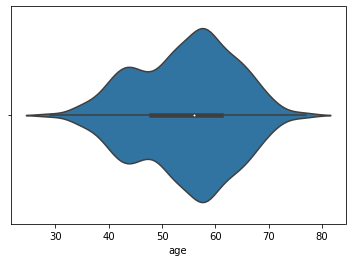

In [16]:
sns.violinplot(x=heart_dataset_new['age'])